# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-09 15:53:38--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [                <=> ] 201.24M  62.8MB/s    in 3.6s    

2023-10-09 15:53:42 (56.6 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV


scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
clf_ridge = Ridge(alpha = 1)
clf_ridge.fit(X_train_scaled, y_train)
alphas =  [0.01, 0.1, 0.3, 0.5, 0.8, 1, 1.5, 3, 8, 12, 20]

In [ ]:
for alpha in alphas:
    clf_ridge = Ridge(alpha = alpha)
    clf_ridge.fit(X_train_scaled, y_train)
    rmse_ridge = mean_squared_error(y_test, clf_ridge.predict(X_test_scaled), squared=False)
    print('Ridge alpha:', alpha, 'rmse:', rmse_ridge)

Ridge alpha: 0.01 rmse: 9.510160708617835
Ridge alpha: 0.1 rmse: 9.510160718781293
Ridge alpha: 0.3 rmse: 9.510160741370306
Ridge alpha: 0.5 rmse: 9.510160763964219
Ridge alpha: 0.8 rmse: 9.510160797864275
Ridge alpha: 1 rmse: 9.510160820470436
Ridge alpha: 1.5 rmse: 9.51016087700727
Ridge alpha: 3 rmse: 9.510161046801462
Ridge alpha: 8 rmse: 9.510161614771647
Ridge alpha: 12 rmse: 9.510162071350832
Ridge alpha: 20 rmse: 9.510162990380705


In [ ]:
model = Ridge(alpha=0.01)
model.fit(X_train_scaled, y_train)
rmse_for_model = mean_squared_error(y_test, model.predict(X_test_scaled), squared=False)
rmse_for_model

9.510160708617835

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
avg = np.mean(model.predict(X_test_scaled))
constant_baseline = np.array([avg] * len(y_test))
avg

1998.480317655283

In [ ]:
best_rmse_metric = mean_squared_error(y_test, constant_baseline, squared=False)
best_rmse_metric

10.851920805547868

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
from torch import nn
from tqdm import tqdm

In [ ]:
X_train_scaled  = torch.tensor(X_train_scaled[:30000])
X_test_scaled = torch.tensor(X_test_scaled[:6000])
y_train = torch.tensor(y_train[:30000], dtype=torch.float64)
y_test = torch.tensor(y_test[:6000], dtype=torch.float64)

In [ ]:
X_train_scaled = torch.column_stack([X_train_scaled, torch.tensor([1] * X_train_scaled.shape[0])])
X_test_scaled = torch.column_stack([X_test_scaled, torch.tensor([1] * X_test_scaled.shape[0])])

In [ ]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!

In [ ]:
w = torch.tensor([1] * 91, dtype=torch.float64, requires_grad=True)
lr = 1
loss_test_list = []
loss_train_list = []
x = list(range(1, 11))

In [ ]:
for epoch in range(10):
    for i in range(1000):
        loss = torch.sqrt(torch.mean((X_train_scaled.matmul(w) - y_train) ** 2))
        loss.backward()
        grad = w.grad
        w.data -= lr * grad
        w.grad.data.zero_()
    loss_train = torch.sqrt(torch.mean((X_train_scaled.matmul(w) - y_train) ** 2))
    loss_test = torch.sqrt(torch.mean((X_test_scaled.matmul(w) - y_test) ** 2))
    loss_test_list.append(loss_test.data)
    loss_train_list.append(loss_train.data)
    print("loss_train =", loss_train.data)
    print("loss_test =", loss_test.data)
    if epoch % 2 == 0:
        lr /= 2

loss_train = tensor(994.7119, dtype=torch.float64)
loss_test = tensor(996.4884, dtype=torch.float64)
loss_train = tensor(498.8927, dtype=torch.float64)
loss_test = tensor(501.0685, dtype=torch.float64)
loss_train = tensor(22.0405, dtype=torch.float64)
loss_test = tensor(22.0094, dtype=torch.float64)
loss_train = tensor(9.3916, dtype=torch.float64)
loss_test = tensor(9.2503, dtype=torch.float64)
loss_train = tensor(9.3808, dtype=torch.float64)
loss_test = tensor(9.2360, dtype=torch.float64)
loss_train = tensor(9.3807, dtype=torch.float64)
loss_test = tensor(9.2348, dtype=torch.float64)
loss_train = tensor(9.3807, dtype=torch.float64)
loss_test = tensor(9.2343, dtype=torch.float64)
loss_train = tensor(9.3807, dtype=torch.float64)
loss_test = tensor(9.2342, dtype=torch.float64)
loss_train = tensor(9.3807, dtype=torch.float64)
loss_test = tensor(9.2341, dtype=torch.float64)
loss_train = tensor(9.3807, dtype=torch.float64)
loss_test = tensor(9.2341, dtype=torch.float64)


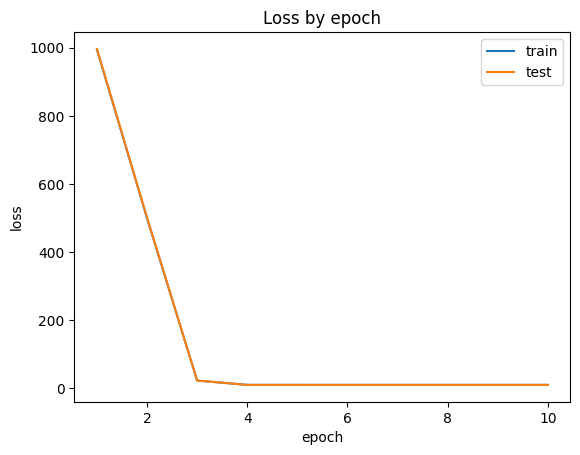

In [ ]:
plt.plot(x, loss_train_list)
plt.plot(x, loss_test_list)
plt.legend(['train', 'test'])
plt.title('Loss by epoch')
plt.xlabel('epoch')
plt.ylabel('loss');

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
from torch.utils.data import DataLoader
from torch.nn import functional as F
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class Our_Dataset(torch.utils.data.Dataset):
    """
    Our dataset
    """

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            self.x[idx, :].clone().detach(),
            self.y[idx].clone().detach()
        )

In [ ]:
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
X_train_scaled = torch.tensor(scaler.fit_transform(X_train))
X_test_scaled = torch.tensor(scaler.transform(X_test))

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

In [ ]:
train_set = Our_Dataset(X_train_scaled, y_train_torch)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = Our_Dataset(X_test_scaled, y_test_torch)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
def RMSE(y_1, y_2):
    return torch.sqrt(torch.mean((y_1 - y_2) ** 2))

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    test_loss = []

    train_loss = []

    for epoch in range(10):
        temp_train_loss = []
        for x_train, y_train in tqdm(train_loader):  # берем батч из трейн лоадера
            y_pred = model(torch.tensor(x_train, dtype=torch.float))  # делаем предсказания
            loss = criterion(y_pred, y_train)  # считаем лосс
            temp_train_loss.append(loss.detach().cpu().numpy())
            loss.backward()  # считаем градиенты обратным проходом
            optimizer.step()  # обновляем параметры сети
            optimizer.zero_grad()  # обнуляем посчитанные градиенты параметров
        train_loss.append(np.mean(temp_train_loss))

        val_loss = []  # сюда будем складывать **средний по бачу** лосс
        with torch.no_grad():  # на валидации запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(test_loader):  # берем батч из валидационного лоадера
                y_pred = model(torch.tensor(x_val, dtype=torch.float))  # делаем предсказания
                loss = criterion(y_pred, y_val)  # считаем лосс
                val_loss.append(loss.cpu().numpy())  # добавляем в массив
        test_loss.append(np.mean(val_loss))

        # печатаем метрики
        print(
            f"Epoch: {epoch}, loss: {np.mean(val_loss)}"
        )
        if np.mean(val_loss) <= 8.75:
          break

    return train_loss, test_loss


Бахнем в лоб нейронную сеть, с тремя FC слоями и двумя нелинейностями и без нормировки таргета.

In [ ]:
model = nn.Sequential(
    nn.Linear(
        90, 200
    ),
    nn.ReLU(),
    nn.Linear(
        200, 100
    ),
    nn.ReLU(),
    nn.Linear(
        100, 1
    )
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = train(model, optimizer, RMSE, train_loader, test_loader)

100%|██████████| 807/807 [00:01<00:00, 757.08it/s]


Epoch: 0, loss: 968.8187255859375


100%|██████████| 807/807 [00:01<00:00, 755.01it/s]


Epoch: 1, loss: 1252.6663818359375


100%|██████████| 807/807 [00:01<00:00, 773.37it/s]


Epoch: 2, loss: 528.5518188476562


100%|██████████| 807/807 [00:01<00:00, 771.87it/s]


Epoch: 3, loss: 9.664801597595215


100%|██████████| 807/807 [00:01<00:00, 779.24it/s]


Epoch: 4, loss: 9.686532974243164


100%|██████████| 807/807 [00:01<00:00, 763.69it/s]


Epoch: 5, loss: 9.625381469726562


100%|██████████| 807/807 [00:01<00:00, 735.71it/s]


Epoch: 6, loss: 9.643107414245605


100%|██████████| 807/807 [00:01<00:00, 751.80it/s]


Epoch: 7, loss: 9.645556449890137


100%|██████████| 807/807 [00:01<00:00, 587.89it/s]


Epoch: 8, loss: 9.68610668182373


100%|██████████| 807/807 [00:01<00:00, 735.13it/s]


Epoch: 9, loss: 9.626315116882324


100%|██████████| 807/807 [00:01<00:00, 531.75it/s]

Epoch: 10, loss: 9.646637916564941


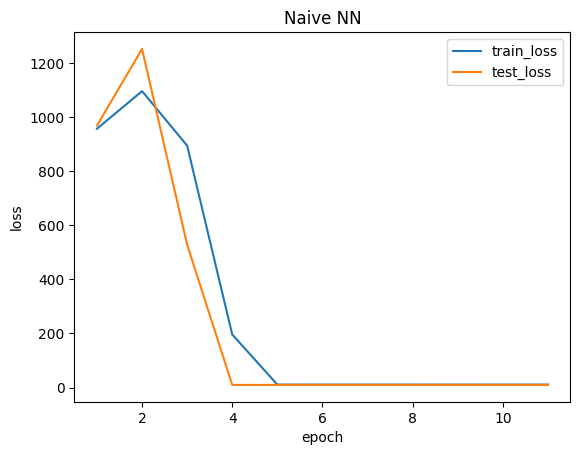

In [ ]:
x = list(range(1, len(losses[0]) + 1))
plt.plot(x, losses[0])
plt.plot(x, losses[1])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Naive NN');

Дальше я проделал следующие операции:
1. Нормировка таргета
2. Уменьшил batch_size до 32
3. Добавил Dropout
4. Установил momentum = 0.5
5. Добавил Batchnorm

**Итог:** На девятой эпохе получил лосс 9.13

P.S. Пока все еще использую SGD оптимизатор

In [ ]:
y_train_torch_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_torch_scaled = scaler.transform(y_test.reshape(-1, 1))

In [ ]:
train_set_scaled = Our_Dataset(X_train_scaled, y_train_torch)
train_loader_scaled = DataLoader(train_set, batch_size=32, shuffle=True)

test_set_scaled = Our_Dataset(X_test_scaled, y_test_torch)
test_loader_scaled = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
model = nn.Sequential(
    nn.Linear(
        90, 400
    ),
    nn.BatchNorm1d(400),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(
        400, 100
    ),
    nn.ReLU(),
    nn.Linear(
        100, 1
    )
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.5)
losses = train(model, optimizer, RMSE, train_loader_scaled, test_loader_scaled)

100%|██████████| 1614/1614 [00:01<00:00, 1020.35it/s]


Epoch: 0, loss: 11.171635627746582


100%|██████████| 1614/1614 [00:01<00:00, 971.67it/s]


Epoch: 1, loss: 17.27701187133789


100%|██████████| 1614/1614 [00:02<00:00, 713.69it/s]


Epoch: 2, loss: 18.276044845581055


100%|██████████| 1614/1614 [00:01<00:00, 1002.26it/s]


Epoch: 3, loss: 10.098831176757812


100%|██████████| 1614/1614 [00:01<00:00, 958.75it/s]


Epoch: 4, loss: 9.714186668395996


100%|██████████| 1614/1614 [00:01<00:00, 979.77it/s]


Epoch: 5, loss: 9.192129135131836


100%|██████████| 1614/1614 [00:01<00:00, 985.62it/s] 


Epoch: 6, loss: 17.286733627319336


100%|██████████| 1614/1614 [00:01<00:00, 961.02it/s]


Epoch: 7, loss: 14.158476829528809


100%|██████████| 1614/1614 [00:01<00:00, 953.17it/s]


Epoch: 8, loss: 19.761720657348633


100%|██████████| 1614/1614 [00:02<00:00, 570.38it/s]


Epoch: 9, loss: 9.13550090789795


100%|██████████| 1614/1614 [00:01<00:00, 1025.61it/s]

Epoch: 10, loss: 14.11577320098877


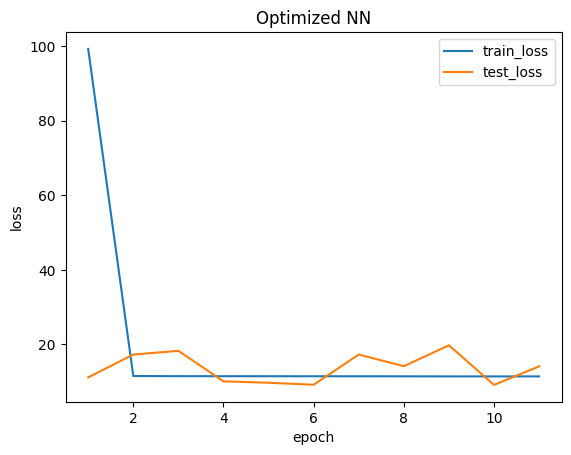

In [ ]:
x = list(range(1, len(losses[0]) + 1))
plt.plot(x, losses[0])
plt.plot(x, losses[1])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Optimized NN with SGD');

Далее произошли следующие изменения:
1. Уменьшение batch_size до 16
2. Использую оптимизатор Adam

**Итог:** loss = 8.753 на 9 эпохе

In [ ]:
train_set_scaled = Our_Dataset(X_train_scaled, y_train_torch)
train_loader_scaled = DataLoader(train_set, batch_size=16, shuffle=True)

test_set_scaled = Our_Dataset(X_test_scaled, y_test_torch)
test_loader_scaled = DataLoader(test_set, batch_size=16, shuffle=False)

In [ ]:
model = nn.Sequential(
    nn.Linear(
        90, 400
    ),
    nn.BatchNorm1d(400),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(
        400, 100
    ),
    nn.ReLU(),
    nn.Linear(
        100, 1
    )
)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.005)
losses = train(model, optimizer, RMSE, train_loader_scaled, test_loader_scaled)

100%|██████████| 3227/3227 [00:02<00:00, 1594.36it/s]


Epoch: 0, loss: 34.80109786987305


100%|██████████| 3227/3227 [00:02<00:00, 1444.23it/s]


Epoch: 1, loss: 37.38286590576172


100%|██████████| 3227/3227 [00:02<00:00, 1511.37it/s]


Epoch: 2, loss: 27.733478546142578


100%|██████████| 3227/3227 [00:02<00:00, 1522.80it/s]


Epoch: 3, loss: 9.131806373596191


100%|██████████| 3227/3227 [00:02<00:00, 1522.91it/s]


Epoch: 4, loss: 8.955052375793457


100%|██████████| 3227/3227 [00:02<00:00, 1426.87it/s]


Epoch: 5, loss: 9.360227584838867


100%|██████████| 3227/3227 [00:02<00:00, 1177.99it/s]


Epoch: 6, loss: 9.723734855651855


100%|██████████| 3227/3227 [00:02<00:00, 1440.70it/s]


Epoch: 7, loss: 8.869196891784668


100%|██████████| 3227/3227 [00:02<00:00, 1504.60it/s]


Epoch: 8, loss: 8.847122192382812


100%|██████████| 3227/3227 [00:02<00:00, 1449.68it/s]


Epoch: 9, loss: 8.753140449523926


100%|██████████| 3227/3227 [00:02<00:00, 1548.37it/s]

Epoch: 10, loss: 8.926032066345215


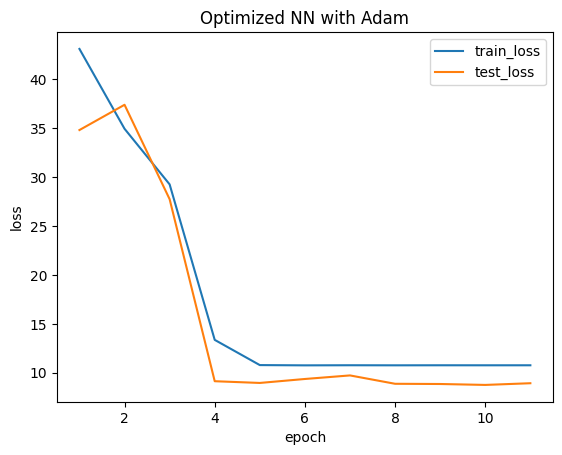

In [ ]:
x = list(range(1, len(losses[0]) + 1))
plt.plot(x, losses[0])
plt.plot(x, losses[1])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Optimized NN with Adam');

Изменения следующие:
1. Уменьшение батча до 12
2. Оптимайзер RMSprop
3. Моментум увеличил до 0.7
4. lr = 0.001

**Итог:** loss = 8.678

In [ ]:
train_set_scaled = Our_Dataset(X_train_scaled, y_train_torch)
train_loader_scaled = DataLoader(train_set, batch_size=12, shuffle=True)

test_set_scaled = Our_Dataset(X_test_scaled, y_test_torch)
test_loader_scaled = DataLoader(test_set, batch_size=12, shuffle=False)

In [ ]:
model = nn.Sequential(
    nn.Linear(
        90, 400
    ),
    nn.BatchNorm1d(400),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    nn.Linear(
        400, 100
    ),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(
        100, 1
    )
)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, momentum=0.7)
losses = train(model, optimizer, RMSE, train_loader_scaled, test_loader_scaled)

100%|██████████| 4303/4303 [00:05<00:00, 793.13it/s]


Epoch: 0, loss: 9.04669189453125


100%|██████████| 4303/4303 [00:05<00:00, 776.12it/s]


Epoch: 1, loss: 8.678324699401855


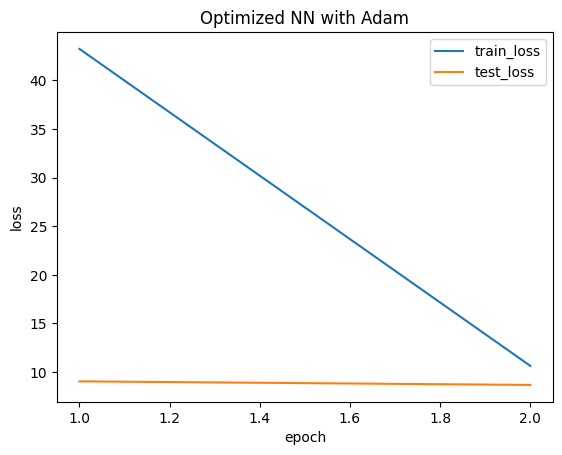

In [ ]:
x = list(range(1, len(losses[0]) + 1))
plt.plot(x, losses[0])
plt.plot(x, losses[1])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Best NN with RMSprop');

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Итоги:**

Сначала было сложно определиться с архитектурой сети, а точнее с количеством слоев, в первой версии я использовал два слоя, но там качество было далеко от нужного, попробовал 3 слоя стало заметно лучше, и в итоге я решил работать с тремя слоями.

Далее я начал искать как лучше сделать архитектуру, а именно как использовать batchnorm и dropout.

Дальше я решил поподбирать размер батчей (что в итоге оказалось главным ключом к успеху), я стал их уменьшать в каждой попытке.

Потом уже почти добившись достаточно хорошего качества, я стал подбирать оптимизатор, сначала попробовал Adagrad, но он не выбивал мне качество на 10, поэтому я попробовал RMSprop. После этого подобрал гиперпараметры momentum и lr и все получилось.

Из ресурсов были использованы документация pytorch  а также:

1. https://machinelearningknowledge.ai/pytorch-optimizers-complete-guide-for-beginner/\

2. https://russianblogs.com/article/43271545711/